<a href="https://colab.research.google.com/github/ParthikB/Vohoo-Tensorflow/blob/master/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import matplotlib.pyplot as plt
import glob, shutil

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 3s 0us/step


In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

total_train = 0
total_val   = 0

for class_ in classes:
  total_train += len(os.listdir(os.path.join(train_dir, class_)))
  total_val   += len(os.listdir(os.path.join(val_dir, class_)))
  
print("Total Training samples   :", total_train)
print("Total Validation samples :", total_val)

Total Training samples   : 2935
Total Validation samples : 735


## Data Augmentation

In [0]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

In [8]:
image_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               shear_range=0.2,
                               rotation_range=40,
                               fill_mode='nearest')

train_data = image_gen.flow_from_directory(directory=train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                           class_mode='binary')

Found 2935 images belonging to 5 classes.


In [9]:
image_gen = ImageDataGenerator(rescale=1./255)

val_data = image_gen.flow_from_directory(directory=val_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=(IMG_SHAPE, IMG_SHAPE),
                                         class_mode='binary')

Found 735 images belonging to 5 classes.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

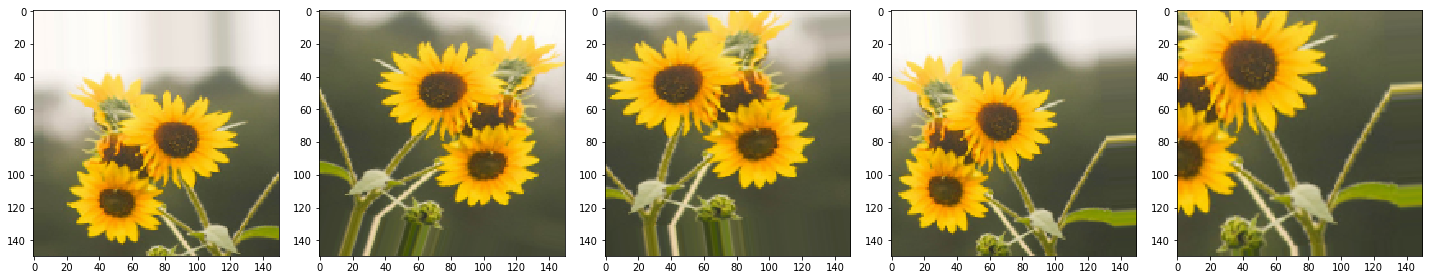

In [11]:
plotImages([train_data[0][0][1] for i in range(5)])

## DNN (structure)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])



In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

## DNN (training)

In [22]:
EPOCHS = 100

history = model.fit_generator(train_data, 
                    steps_per_epoch=int(np.ceil(total_train/BATCH_SIZE)),
                    validation_data=val_data,
                    validation_steps=int(np.ceil(total_val/BATCH_SIZE)),
                    epochs=EPOCHS)

model.save("model1.tfl")

Epoch 1/100
30/30 [==============================] - 25s 818ms/step - loss: 1.5872 - acc: 0.2664 - val_loss: 1.3866 - val_acc: 0.4218
Epoch 2/100
30/30 [==============================] - 21s 702ms/step - loss: 1.3420 - acc: 0.4031 - val_loss: 1.1921 - val_acc: 0.4748
Epoch 3/100
30/30 [==============================] - 20s 676ms/step - loss: 1.2514 - acc: 0.4467 - val_loss: 1.2767 - val_acc: 0.4626
Epoch 4/100
30/30 [==============================] - 21s 684ms/step - loss: 1.2013 - acc: 0.4688 - val_loss: 1.1510 - val_acc: 0.4844
Epoch 5/100
30/30 [==============================] - 20s 680ms/step - loss: 1.1951 - acc: 0.4743 - val_loss: 1.1683 - val_acc: 0.5129
Epoch 6/100
30/30 [==============================] - 20s 683ms/step - loss: 1.1382 - acc: 0.5169 - val_loss: 1.1265 - val_acc: 0.5088
Epoch 7/100
30/30 [==============================] - 20s 670ms/step - loss: 1.0932 - acc: 0.5421 - val_loss: 1.0303 - val_acc: 0.5891
Epoch 8/100
30/30 [==============================] - 20s 674ms

In [0]:
train_loss = history.history['loss']
train_acc  = history.history['acc']

val_loss   = history.history['val_loss']
val_acc    = history.history['val_acc']

epochs = range(100)

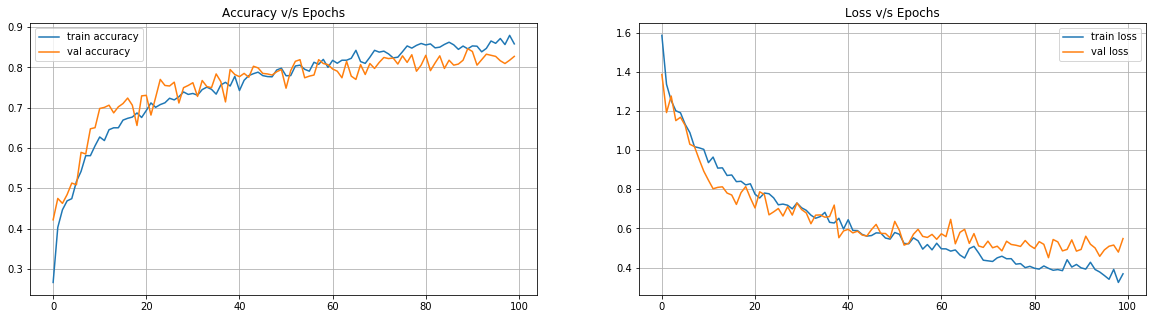

In [30]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.grid(1)
plt.plot(epochs, train_acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title("Accuracy v/s Epochs")
plt.legend()


plt.subplot(1, 2, 2)
plt.grid(1)
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title("Loss v/s Epochs")
plt.legend()